In [2]:
%matplotlib inline
from numpy import *
from scipy.stats import *
from numpy.random import *
from matplotlib.pyplot import *

In [3]:
class AdversarialArm():
  def __init__(self, t, active_start, active_end, period):
    self.t = t
    self.active_start = active_start
    self.active_end = active_end
    self.period = period
  
  def draw(self):
    self.t = self.t + 1
    if self.active_start <= self.t%self.period <= self.active_end:
      return 1.0
    else:
      return 0.0

In [4]:
# loss with prob p
class BernoulliArm():
  def __init__(self, p):
    self.p = p
  
  def draw(self):
    if binomial(1, self.p) > self.p:
      return 1.0
    else:
      return 0.0

In [5]:
class ConstArm():
    def __init__(self, loss):
        self.loss = loss
        
    def draw(self):
        return self.loss

In [6]:
def categorical_draw(probs):
  z = uniform(0, 1)
  cum_prob = 0.0
  for i in range(len(probs)):
    prob = probs[i]
    cum_prob += prob
    if cum_prob > z:
      return i

  return len(probs) - 1


In [7]:
class Eta():
    def __init__(self, t):
        self.t = 0
        return
    
    def initialize(self):
        self.t =0
        return 
    
    def get(self, n_arms):
        self.t = self.t + 1
        return sqrt(log(n_arms)/(n_arms*self.t))

In [8]:
class ConstEta():
    def __init__(self, eta):
        self.eta = eta
        return
    
    def initialize(self):
        self.eta = self.eta
        return
    
    def get(self, n_arms):
        return self.eta

In [9]:
class Exp3():
  def __init__(self, gamma, weights):
    self.gamma = gamma
    self.weights = weights
    self.t = 0
    return
  
  def initialize(self, n_arms):
    self.weights = [1.0 for i in range(n_arms)]
    self.t = 0
    return

  def select_arm(self, eta):
    self.t += 1    
    n_arms = len(self.weights)
    self.eta = eta.get(n_arms)
    self.gamma = self.eta/2.0
    total_weight = sum(self.weights)
    probs = [0.0 for i in range(n_arms)]
    for arm in range(n_arms):
      probs[arm] = (1 - self.gamma) * (self.weights[arm] / total_weight)
      probs[arm] = probs[arm] + (self.gamma) * (1.0 / float(n_arms))
    return categorical_draw(probs)

  def update(self, chosen_arm, loss): 
    n_arms = len(self.weights)
    total_weight = sum(self.weights)
    probs = [0.0 for i in range(n_arms)]
    for arm in range(n_arms):
      probs[arm] = (1 - self.gamma) * (self.weights[arm] / total_weight)
      probs[arm] = probs[arm] + (self.gamma) * (1.0 / float(n_arms))
    
    x = loss / probs[chosen_arm]
    
    loss_factor = math.exp(-self.eta * x)
    self.weights[chosen_arm] = self.weights[chosen_arm] * loss_factor

In [10]:
class Exp3IX():
    def __init__(self, gamma, weights):
        self.gamma = gamma
        self.weights = weights
        return
    
    def initialize(self, n_arms):
        self.weights = [1.0 for i in range(n_arms)]
        self.t = 0
        return
    
    def select_arm(self, eta):
        self.t += 1
        n_arms = len(self.weights)
        self.eta = eta.get(n_arms)
        self.gamma = self.eta/2.0
        total_weight = sum(self.weights)
        probs = [0.0 for i in range(n_arms)]
        for arm in range(n_arms):
            probs[arm] = (1 - self.gamma) * (self.weights[arm] / total_weight)
            probs[arm] = probs[arm] + (self.gamma) * (1.0 / float(n_arms))
        return categorical_draw(probs)
    
    def update(self, chosen_arm, loss):
        n_arms = len(self.weights)
        total_weight = sum(self.weights)
        probs = [0.0 for i in range(n_arms)]
        for arm in range(n_arms):
            probs[arm] = (1 - self.gamma) * (self.weights[arm] / total_weight)
            probs[arm] = probs[arm] + (self.gamma) * (1.0 / float(n_arms))
            
        x = loss / (probs[chosen_arm] + self.gamma)
        loss_factor = math.exp(-self.eta * x)
        self.weights[chosen_arm] = self.weights[chosen_arm] * loss_factor

In [11]:
class FullInfo():
    def __init__(self, weights):
        self.weights = weights
        return
    
    def initialize(self, n_arms):
        self.weights = array([1.0 for i in range(n_arms)])
        self.t = 0
        return
    
    def select_arm(self, eta):
        self.t += 1
        n_arms = len(self.weights)
        self.eta = eta.get(n_arms)
        total_weight = sum(self.weights)
        probs = [0.0 for i in range(n_arms)]
        for arm in range(n_arms):
            probs[arm] = (self.weights[arm] / total_weight)
        return categorical_draw(probs)
    
    def update(self, chosen_arm, loss):
        n_arms = len(self.weights)
        total_weight = sum(self.weights)
        loss = array(loss)
        self.weights = self.weights * exp(-self.eta * loss)

In [12]:
class VaW():
    def __init__(self, weights):
        self.weights = weights
        return
    
    def initialize(self, n_arms):
        self.weights = array([1.0 for i in range(n_arms)])
        self.cumloss = array([0.0 for i in range(n_arms)])
        self.t = 0
        return
    
    def select_arm(self, eta):
        self.t += 1
        n_arms = len(self.weights)
        self.eta = eta.get(n_arms)
        total_weight = sum(self.weights)
        probs = [0.0 for i in range(n_arms)]
        for arm in range(n_arms):
            probs[arm] = (self.weights[arm] / total_weight)
        return categorical_draw(probs)
    
    def update(self, chosen_arm, loss):
        self.cumloss += loss
        self.rmean = self.cumloss/self.t
        loss = array(loss)
        ltilda = loss + (4*self.eta*(loss-self.rmean)**2)
        self.weights = self.weights * exp(-self.eta * ltilda)

In [21]:
def test_algorithm(algo, arms, eta, num_sims=100, horizon=100, best_arm=1):
    regret = []
    weights = []
    for sim in range(num_sims):
        cumulative_loss = 0
        bloss = 0
        algo.initialize(len(arms))
        eta.initialize()
        for t in range(horizon):
            t = t + 1
            chosen_arm = algo.select_arm(eta)
            loss = arms[chosen_arm].draw()
            bloss = bloss + arms[best_arm].draw()
            if t == 1:
                cumulative_loss = loss
            else:
                cumulative_loss = cumulative_loss + loss
            algo.update(chosen_arm, loss)
        weights.append(algo.weights)    
        regret.append(cumulative_loss - bloss)
    return mean(regret), weights

In [14]:
def test_falgorithm(algo, arms, eta, num_sims=100, horizon=100, best_arm=1):
    regret = []
    weights = []
    for sim in range(num_sims):
        cumulative_loss = 0
        bloss = 0
        algo.initialize(len(arms))
        eta.initialize()
        for t in range(horizon):
            t = t + 1
            chosen_arm = algo.select_arm(eta)
            loss = arms[chosen_arm].draw()
            bloss = bloss + arms[best_arm].draw()
            cumulative_loss = cumulative_loss + loss
            lvector = []
            for arm in arms:
                lvector.append(arm.draw())
            algo.update(chosen_arm, lvector)
        weights.append(algo.weights)    
        regret.append(cumulative_loss - bloss)
    return mean(regret), weights

In [15]:
def test_function(arms, horizon, num_sims = 1000, best_arm = 1):
    arms = [ConstArm(1), ConstArm(0)]
    algo = Exp3IX(.1, [])
    eta = Eta(0)
    return test_algorithm(algo, arms, eta, num_sims, horizon, best_arm)

In [16]:
def test_full(horizon, num_sims = 1000, best_arm = 1, eta=Eta(0)):
    arms = [BernoulliArm(.75), ConstArm(0)]
    algo = FullInfo([])
    return test_falgorithm(algo, arms, eta, num_sims, horizon, best_arm)

\textbf{Full information setting:}\bigbreak I started my enquiry from the initial observation that in Variational Multiplicative weights(VW) algorithm the update is done as below.\bigbreak
$w_t(i)=w_{t-1}(i)exp(-\eta f^{~}_{t-1}(i))$  where $f^{~}_{t-1}(i)=l_{t-1}(i)+4\eta Q_{i}^2$ \bigbreak
This means VW is equivalent exp algorithm in full information setting when the loss vectors are constant.\bigbreak The plot is obtained in the following experimental setup:\bigbreak No.of arms $=2$ \newline Loss vector for arm $1$  is $1$ \newline Loss vector for arm  $2$  is $0$ \newline Plot below shows how regret grows in a full info setting for $\eta$ which decays as $\frac{1}{\sqrt{t}}$ 

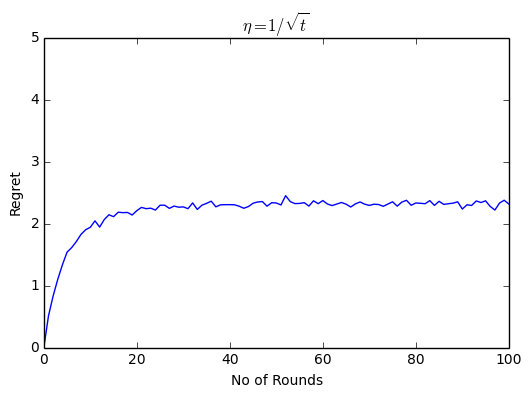

In [16]:
regret=[]
arms = [ConstArm(1), ConstArm(0)]
algo = FullInfo([])
horizon = 100
for i in range(horizon+1):
    regret.append(test_falgorithm(algo, arms, eta=Eta(0), num_sims=1000, horizon=i, best_arm=1)[0])
figure(1)
xlim(0,100)
ylim(0,5)
title("$\eta=1/\sqrt{t}$")
xlabel("No of Rounds")
ylabel("Regret")
plot(regret)
show()

"An additional difficulty which arises is the fact that a learning rate parameter $\eta$ needs to be set based on the total variation $Q$"[Better Algorithms for Benign Bandits]. In VaW algorithm[Extracting Certainty from Uncertainty: Regret Bounded by Variation in Costs] $\eta$ is chosen as $\min(\sqrt{\frac{\log{k}}{4Q}},{\frac{1}{10}})$.\bigbreak
The plots below show Regret as a function of eta for different loss sequences in full information setting. For the plot on left, the loss sequences are constant with means $1$ and $0$ respectively. The plot on the the right also has a const loss vector with means $0.5$ $0.4$ respectively. Evidently, when the $Q$ is low the a higher learning rate is advantageous.

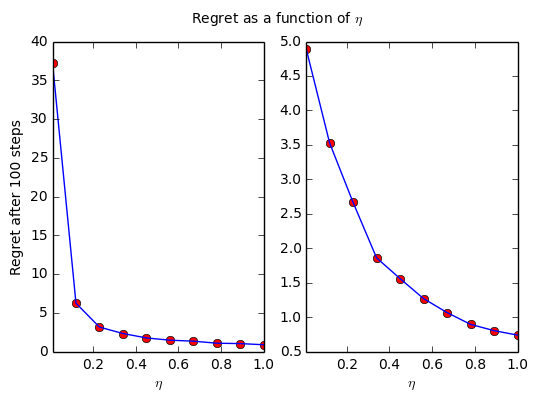

In [56]:
figure(2)
subplot(1,2,1)
regret=[]
arms = [ConstArm(1), ConstArm(0)]
algo = FullInfo([])
for i in linspace(10**-2, 1, 10):
    regret.append(test_falgorithm(algo, arms, eta=ConstEta(i), num_sims=100, horizon=100, best_arm=1)[0])
xlabel("$\eta$")
ylabel("Regret after 100 steps")
xlim(10**-2,1)
suptitle("Regret as a function of $\eta$ ")
plot(linspace(10**-2, 1, 10),regret,'ro')
plot(linspace(10**-2, 1, 10), regret)
subplot(1,2,2)
regret=[]
arms = [ConstArm(.5), ConstArm(0.4)]
algo = FullInfo([])
for i in linspace(10**-2, 1, 10):
    regret.append(test_falgorithm(algo, arms, eta=ConstEta(i), num_sims=100, horizon=100, best_arm=1)[0])
xlabel("$\eta$")
xlim(10**-2,1)
plot(linspace(10**-2, 1, 10),regret,'ro')
plot(linspace(10**-2, 1, 10), regret)
show()

Now we consider the following situation where the losses are obtained from Bernoulli distribution. The mean of the loss sequences for the plot on left are $.5$ and $.1$, and the plot on the right has mean of $.5$ and $.4$. Clearly, the choice of $\eta$ is not trvial.\bigbreak

However, inutively, we need a lower bound on $\eta$, when it is dependent on $Q$ as it can go to $0$. Also, $\eta$ should be inversely proportional to $Q$. This is to ensure we don't penalize arms with higher $Q's$ as they can have higher means, whereas, $\eta$ would be higher, if they have low $Q$.\bigbreak

$Q$ is estimated by doubling trick in an online fashion in the above case.[Online Learning and Online
Convex Optimization; Shai Shalev-Shwartz; 2.3.1]

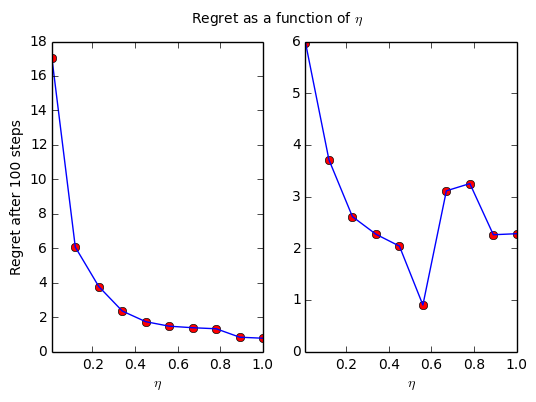

In [57]:
figure(3)
subplot(1,2,1)
regret=[]
arms = [BernoulliArm(.5), BernoulliArm(.1)]
algo = FullInfo([])
for i in linspace(10**-2, 1, 10):
    regret.append(test_falgorithm(algo, arms, eta=ConstEta(i), num_sims=100, horizon=100, best_arm=1)[0])
xlabel("$\eta$")
ylabel("Regret after 100 steps")
xlim(10**-2,1)
suptitle("Regret as a function of $\eta$ ")
plot(linspace(10**-2, 1, 10),regret,'ro')
plot(linspace(10**-2, 1, 10), regret)
subplot(1,2,2)
regret=[]
arms = [BernoulliArm(.5), BernoulliArm(0.4)]
algo = FullInfo([])
for i in linspace(10**-2, 1, 10):
    regret.append(test_falgorithm(algo, arms, eta=ConstEta(i), num_sims=100, horizon=100, best_arm=1)[0])
xlabel("$\eta$")
xlim(10**-2,1)
plot(linspace(10**-2, 1, 10),regret,'ro')
plot(linspace(10**-2, 1, 10), regret)
show()

The plot below shows how regret grows for VaW and EXP algorithms, when one of the arm follows bernoulli distributions.

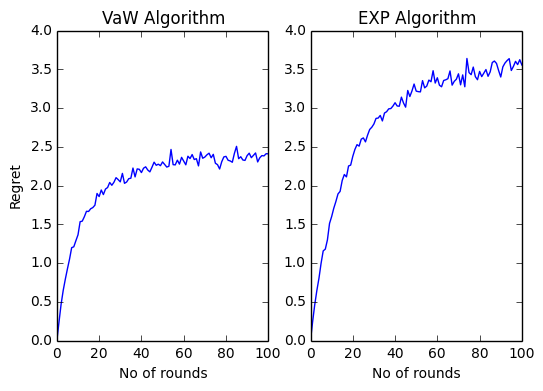

In [20]:
figure(4)
subplot(1,2,1)
horizon = 100
regret=[]
arms = [BernoulliArm(.5), ConstArm(0)]
algo = VaW([])
for i in range(horizon+1):
    regret.append(test_falgorithm(algo, arms, eta=Eta(0), num_sims=1000, horizon=i, best_arm=1)[0])
xlabel("No of rounds")
ylabel("Regret")
title("VaW Algorithm")
ylim(0,4)
plot(regret)
regret=[]
subplot(1,2,2)
arms = [BernoulliArm(.5), ConstArm(0)]
algo = FullInfo([])
for i in range(horizon+1):
    regret.append(test_falgorithm(algo, arms, eta=Eta(0), num_sims=1000, horizon=i, best_arm=1)[0])
xlabel("No of rounds")
title("EXP Algorithm")
ylim(0,4)
plot(regret)
show()

\textbf{Bandit Setting:}\bigbreak 
Now, we study the behavior of EXP3 and EXP3-IX(standard parameters as given in references) for various loss sequences.
The plot below corresponds to const loss sequences, and contrasts EXP3 with FullInfosetting.

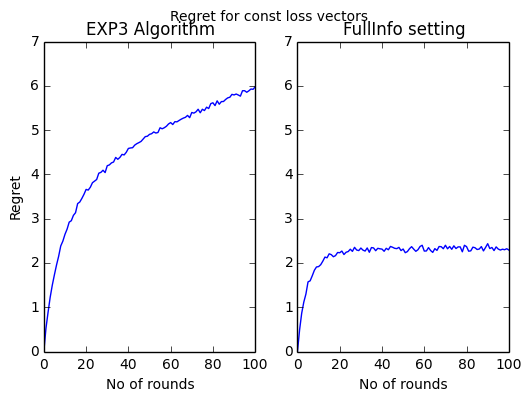

In [25]:
figure(6)
subplot(1,2,1)
horizon = 100
regret=[]
arms = [ConstArm(1), ConstArm(0)]
algo = Exp3(.1, [])
for i in range(horizon+1):
    regret.append(test_algorithm(algo, arms, eta=Eta(0), num_sims=1000, horizon=i, best_arm=1)[0])
xlabel("No of rounds")
ylabel("Regret")
ylim(0,7)
suptitle("Regret for const loss vectors")
title("EXP3 Algorithm")
plot(regret)
regret=[]
subplot(1,2,2)
arms = [ConstArm(1), ConstArm(0)]
algo = FullInfo([])
for i in range(horizon+1):
    regret.append(test_falgorithm(algo, arms, eta=Eta(0), num_sims=1000, horizon=i, best_arm=1)[0])
xlabel("No of rounds")
title("FullInfo setting")
ylim(0,7)
plot(regret)
show()

\pagebreak This plot contrasts EXP3 and EXP3-IX for const loss sequences

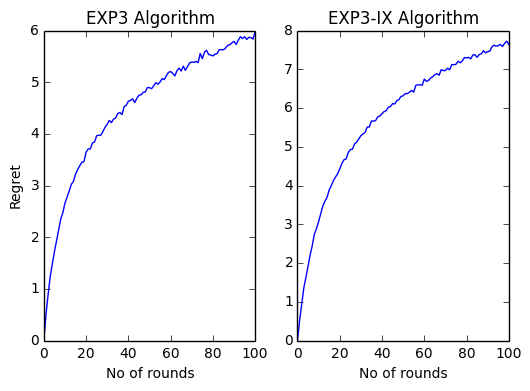

In [22]:
figure(5)
subplot(1,2,1)
horizon = 100
regret=[]
arms = [ConstArm(1), ConstArm(0)]
algo = Exp3(.1, [])
for i in range(horizon+1):
    regret.append(test_algorithm(algo, arms, eta=Eta(0), num_sims=1000, horizon=i, best_arm=1)[0])
xlabel("No of rounds")
ylabel("Regret")
title("EXP3 Algorithm")
plot(regret)
regret=[]
subplot(1,2,2)
arms = [ConstArm(1), ConstArm(0)]
algo = Exp3IX(.1, [])
for i in range(horizon+1):
    regret.append(test_algorithm(algo, arms, eta=Eta(0), num_sims=1000, horizon=i, best_arm=1)[0])
xlabel("No of rounds")
title("EXP3-IX Algorithm")
plot(regret)
show()

This plot contrasts EXP3 and EXP3-IX for loss sequences, where one arm follows Bernoulli distribution with mean $.8$, and one const sequence with mean $0$

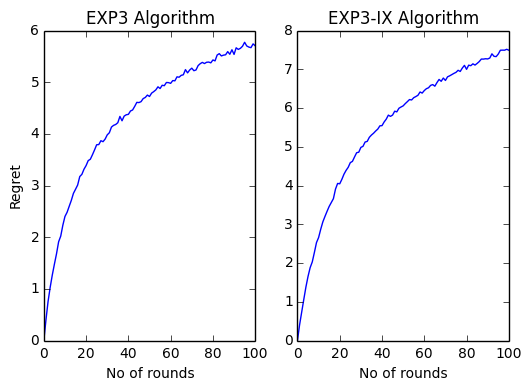

In [27]:
figure(7)
subplot(1,2,1)
horizon = 100
regret=[]
arms = [BernoulliArm(.8), ConstArm(0)]
algo = Exp3(.1, [])
for i in range(horizon+1):
    regret.append(test_algorithm(algo, arms, eta=Eta(0), num_sims=1000, horizon=i, best_arm=1)[0])
xlabel("No of rounds")
ylabel("Regret")
title("EXP3 Algorithm")
plot(regret)
regret=[]
subplot(1,2,2)
arms = [BernoulliArm(.8), ConstArm(0)]
algo = Exp3IX(.1, [])
for i in range(horizon+1):
    regret.append(test_algorithm(algo, arms, eta=Eta(0), num_sims=1000, horizon=i, best_arm=1)[0])
xlabel("No of rounds")
title("EXP3-IX Algorithm")
plot(regret)
show()

\textbf{Dependence on Gamma:} I'm not entirely sure how I could capture the dependence between $\gamma$ and $\eta$. But, I'm convinced(intutively) that as with $\eta$, $\gamma$ could be related to $Q$ in a similar fashion. Also, I couldn't fully comprehend the way they [Better Algorithms for Benign Bandits] have handled these non-trivial problems.\bigbreak

\textbf{References:}
\begin{itemize}
  \item Better Algorithms for Benign Bandits
  \item Online Learning and Online Convex Optimization; Shai Shalev-Shwartz
  \item Extracting Certainty from Uncertainty
\end{itemize}
